In [41]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# League of Legends Predictor - Insights

This Jupyter Notebook is dedicated to gaining insights using data analysis into what are important attributes when it comes to winning the game of League of Legends.

The *match_summary_min.csv* data files were derived by my own script (found in the **riotGamesAPI.py** file). The script allows to specify the desired minute to which the match summary should be made. In this work I have decided to investigate the matches at times between **5-40** minutes. As not a lot happens before 5 minutes into the match, that time will not be analysed.

### Data Structure

Let´s first look at how the data is structured.

In [42]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

dir_path = os.path.join(os.getcwd(), "data")

max_min = 40 #min
min_min = 5 #min
n_files = max_min-min_min+1
data = {}

for i in range(n_files):
    data["data_"+str(5+i)+"min"] = pd.read_csv(os.path.join(dir_path, "match_summary_"+str(5+i)+"min.csv"), 
                                               dtype=int, 
                                               index_col=0)

The games are summarized in terms of the following features/attributes:

In [43]:
print(", ".join(list(data["data_5min"].keys())))

blueWin, blueGold, blueExp, blueLvl, blueCS, blueJngCS, blueVisionScore, blueTowerScore, blueDrakeScore, blueHeraldScore, blueBaronScore, blueKillScore, blueDeathScore, blueAssistScore, redGold, redExp, redLvl, redCS, redJngCS, redVisionScore, redTowerScore, redDrakeScore, redHeraldScore, redBaronScore, redKillScore, redDeathScore, redAssistScore, blueExpDiff, blueLvlDiff, blueGoldDiff, blueDrakeDiff, blueBaronDiff, blueHeraldDiff


The majority of the attributes are absolute, like **blueGold**, **blueExp** and others. They summarize the total power level of each of the teams, irrespective of the power level of the team. This absolute measure is more a measure of time elapsed in-game, thefore also have included other engineered features denoted by the suffix **-Diff**. These measure the relative power of both teams.

### General Data Properties

We have 6 data sets of different sizes. This is because some games end before 20 minutes as an example. That means such a game cannot be included in that dataset. This gives some general information what is the distribution of game times in the games we have analyzed (with a 5 min resolution).

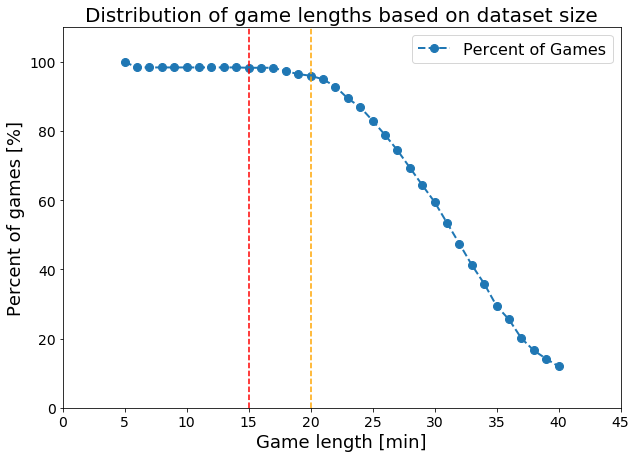

In [44]:
percent_games = [len(data["data_"+str(i + 5)+"min"])/len(data["data_5min"])*100 for i in range(n_files)]

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title("Distribution of game lengths based on dataset size", fontsize =20)

ax.plot([5+i for i in range(n_files)], percent_games, marker='o', linestyle='dashed', linewidth=2, markersize=8)

ax.legend(["Percent of Games"], fontsize =16)
ax.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40, 45], fontsize=14)
ax.axvline(x = 15, linestyle="--", color="red", label="15 min")
ax.axvline(x = 20, linestyle="--", color="orange", label="15 min")
ax.set_xlim(0, 45)
ax.set_ylim(0, 110)
ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=14)
ax.set_xlabel("Game length [min]", fontsize=18)
ax.set_ylabel("Percent of games [%]", fontsize=18)
plt.show()

As you can see, the vast majority of games lasts at least 20 minutes. Only 80% of games are longer than 25 minutes and only 60% of games is longer than 30 minutes. A pretty large drop of can be seen at 30 minutes after which the proportion of games that lasts longer falls steadily.

We have highlighted the boundaries at <b><span style="color:red">15</span></b> and <b><span style="color:orange">20</span></b> minutes. These are noteworthy because at these times the surrender feature becomes available to the teams. At <b><span style="color:red">15 minutes</span></b> all 5 teammates have to agree to the surrender, while at <b><span style="color:orange">20 minutes</span></b> only 4 teammates have to agree to the surrender. Still a very small portion of the games seems to end in such a way at these specific times.

### Correlations

Let´s look at what is important to win the game. This can be done for each dataset, somewhat tentatively showing what is most important to win the game at each point of the game. Keep in mind, that especially for the earliest datasets (<15min) a lot of the game time still has to be played, so we expect these correlations to be relatively weak.

In [46]:
data["data_10min"].corr()["blueWin"].sort_values(ascending=False)

blueWin            1.000000
blueGoldDiff       0.454874
blueExpDiff        0.431242
blueLvlDiff        0.412077
blueExp            0.351765
blueGold           0.351442
blueLvl            0.334908
redDeathScore      0.249053
blueKillScore      0.249053
blueCS             0.242044
blueAssistScore    0.189006
blueDrakeDiff      0.162089
blueJngCS          0.149047
blueDrakeScore     0.128433
blueVisionScore   -0.004267
redVisionScore    -0.032345
redJngCS          -0.113860
redDrakeScore     -0.134816
redCS             -0.158943
redAssistScore    -0.180032
blueDeathScore    -0.266230
redKillScore      -0.266230
redLvl            -0.279825
redExp            -0.304723
redGold           -0.325630
blueTowerScore          NaN
blueHeraldScore         NaN
blueBaronScore          NaN
redTowerScore           NaN
redHeraldScore          NaN
redBaronScore           NaN
blueBaronDiff           NaN
blueHeraldDiff          NaN
Name: blueWin, dtype: float64

As yu can see, a lot of the values are *NaN*. There is nothing wrong with the data. Instead, noting that the data we inspected was for after 5 minutes of play, no drakes, heralds, barons, towers and so on could be taken at that point of the game. So that data is not relevant at that time.

In [50]:
features = list(data["data_5min"].keys())[1:]

correlations = {key: [] for key in features}
for summary in data.values():
    corr = summary.corr()["blueWin"]    
    for key in features:
        correlations[key].append(corr[key])

Let´s plot the correlation coefficients of all of the parameters for the different game lengths.

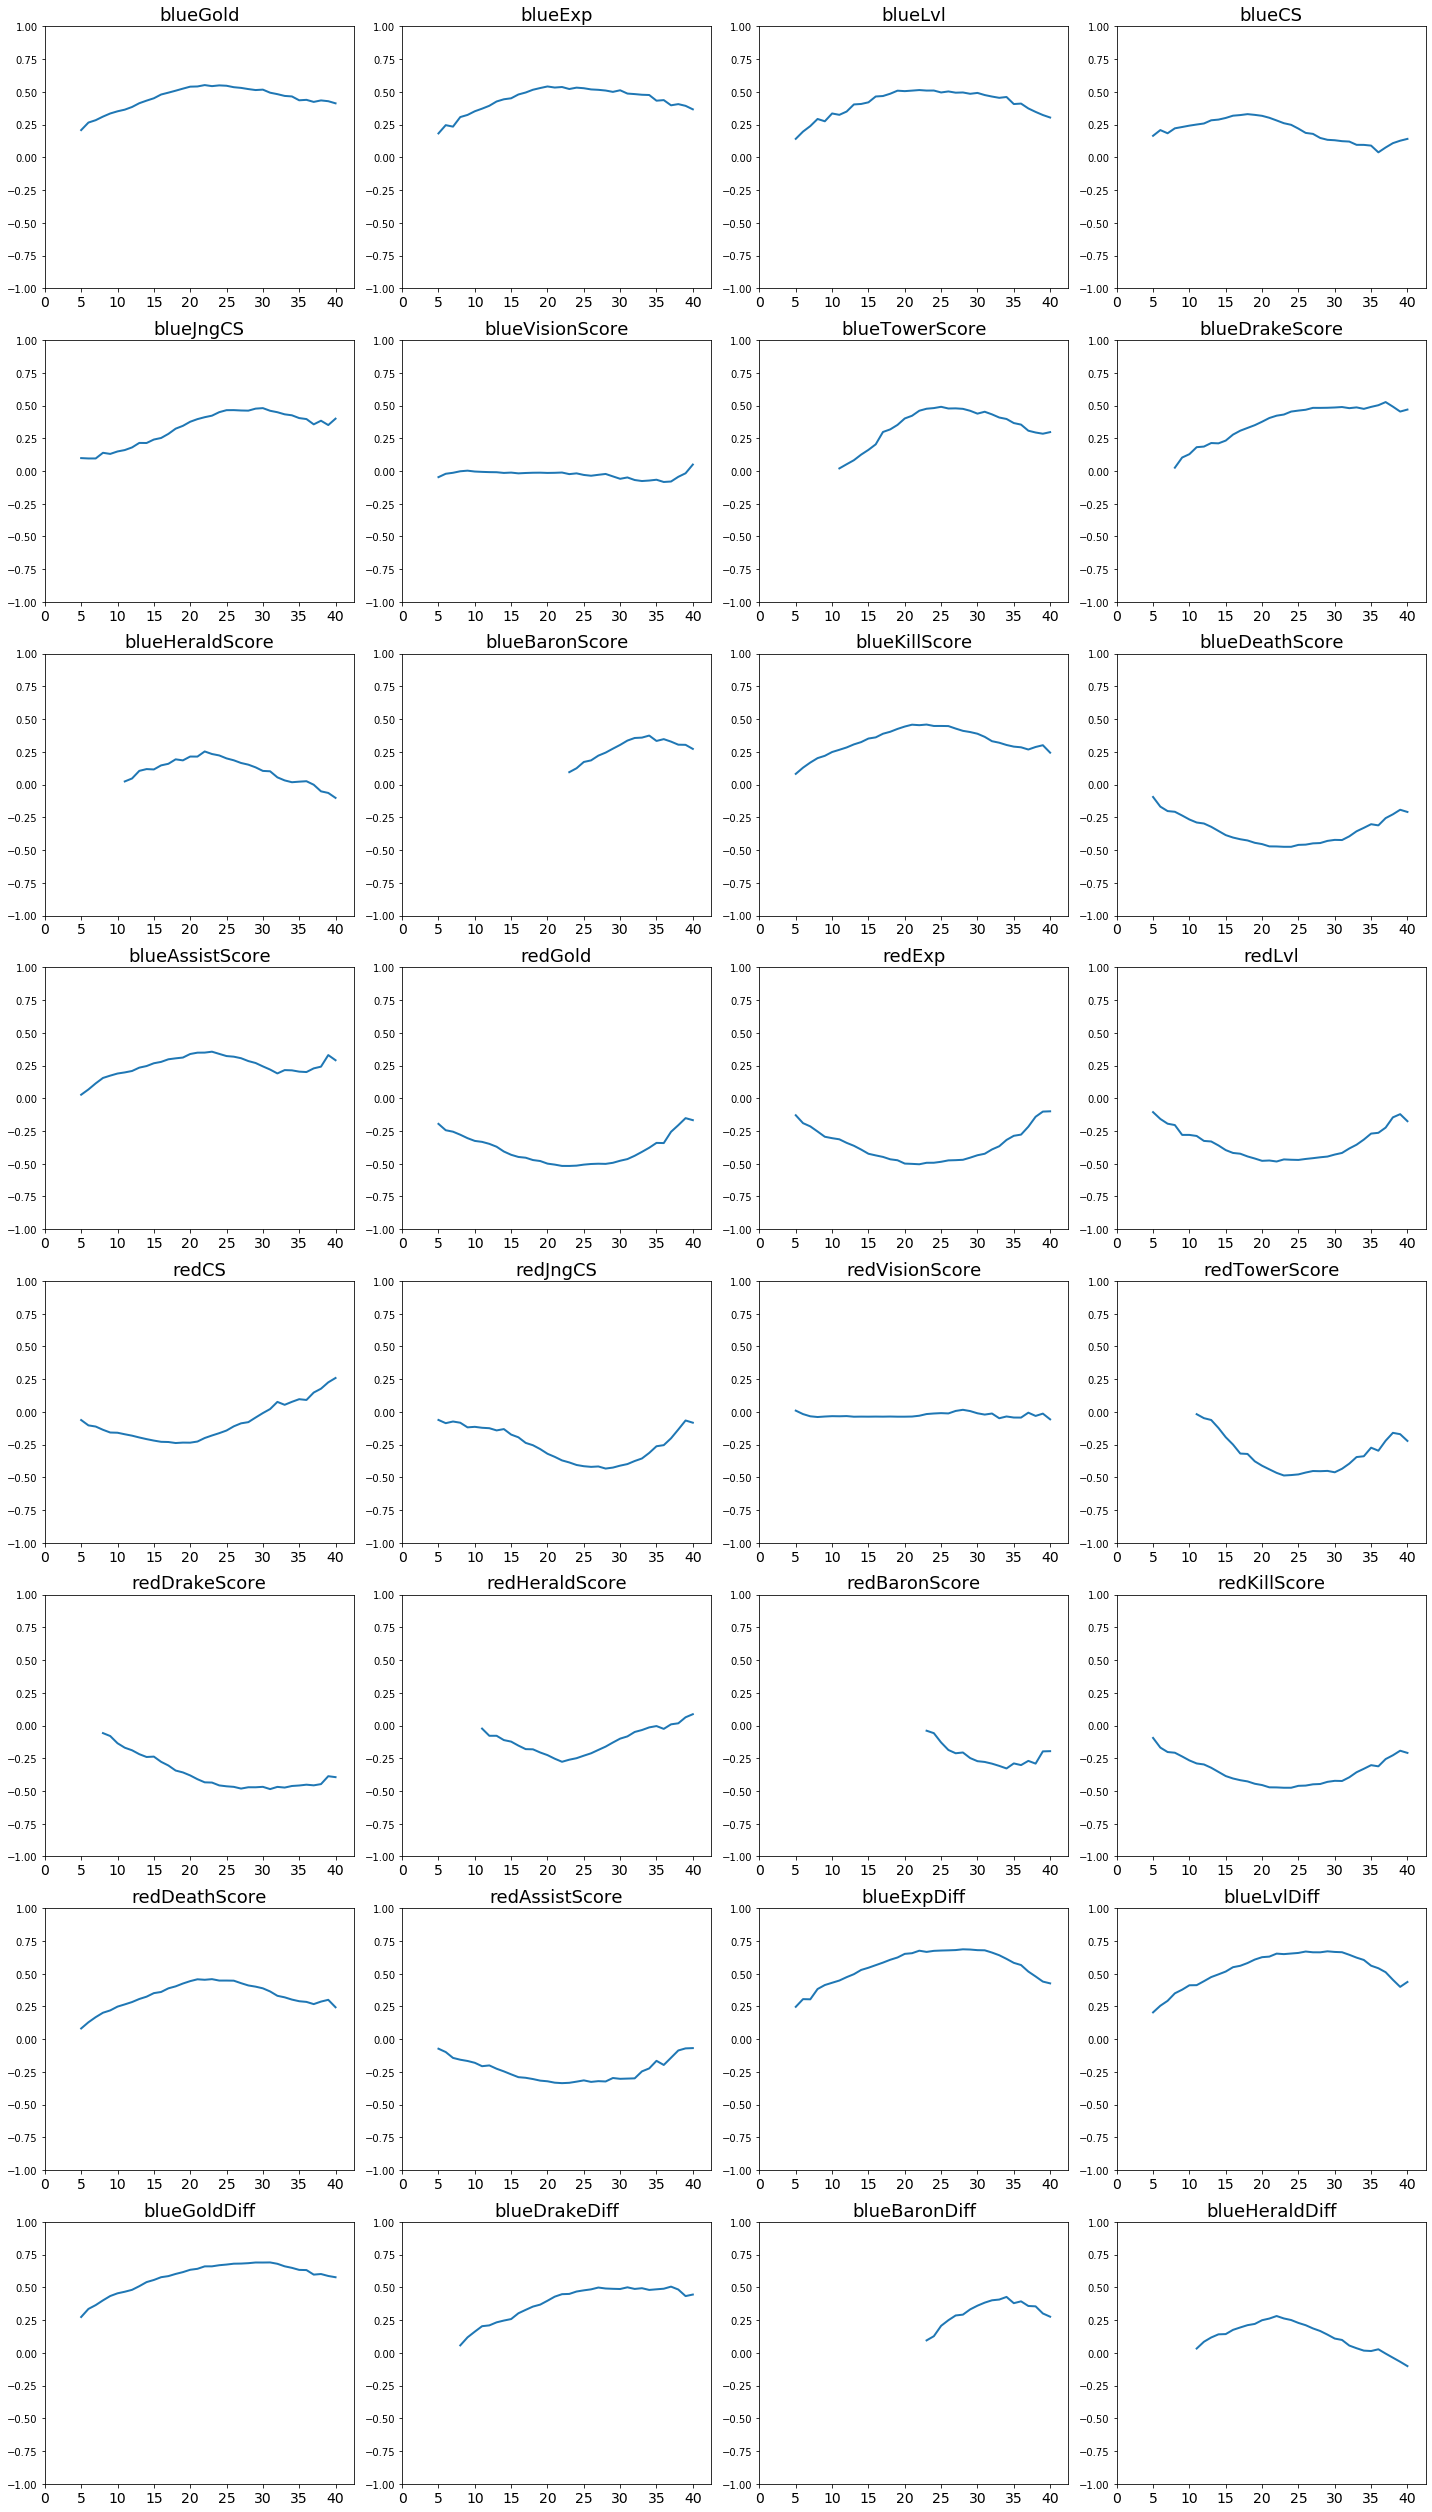

In [56]:
n_rows = 8
n_columns = 4
x_axis = [i+5 for i in range(n_files)]
corr_index = np.array([i for i in range(n_rows*n_columns)]).reshape((n_rows, -1))

fig, ax = plt.subplots(n_rows, n_columns, figsize=(20,35))
 
for k in range(n_rows):
    for l in range(n_columns):
        try:
            feature = features[corr_index[k, l]]
            ax[k, l].set_title(feature, fontsize=18)
            ax[k, l].plot(x_axis, correlations[feature], linestyle='-', linewidth=2)
            ax[k, l].set_xlim(0, 42.5)
            ax[k, l].set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=14)
            ax[k, l].set_ylim(-1, 1)
        except:
            pass
plt.tight_layout()      
plt.show()

Some interesting and unexpected observations can be made. 

Let´s first look at the features associated with heralds, ie. **blueHeraldScore**, **blueHeraldDiff**. One can see that its correlation with winning is largest at 20 minutes and falls of as the game gets longer. Furthermore, at 30 min killing the herald seems to lose all correlation with winning if the game reaches 30 minutes.

It´s also interesting to look at **blueGold**, **blueExp** and **blueKillScore**. It´s correlation is biggest at 20 minutes after which is saturates and even starts to fall. This indicates that at very long game times (>30min), if the team has a significant gold/exp/lvl/kill lead and has not been able to win the game, the likelihood of winning the game starts to drop. Also at these times, players have already accumulated a lot of the gold and experience that is usefull as players can build only 6 items and have a maximum level of 18. This means that gold and exp at that time becomes irrelevant.

Let´s now try to visualize the data somehow. We will decompose the data using t-SNE and PCA into 2D and 3D to try to see if a clear decision boundary arises for our future machine learning efforts.

In [57]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

y = np.array(data["data_20min"]["blueWin"])
X = data["data_20min"].drop("blueWin", axis=1).values

X_tsne_2D = TSNE(n_components=2).fit_transform(StandardScaler().fit_transform(X))
X_tsne_3D = TSNE(n_components=3).fit_transform(StandardScaler().fit_transform(X))
print("t_SNE finished.")
X_pca_2D = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))
X_pca_3D = PCA(n_components=3).fit_transform(StandardScaler().fit_transform(X))
print("PCA finished.")

t_SNE finished.
PCA finished.


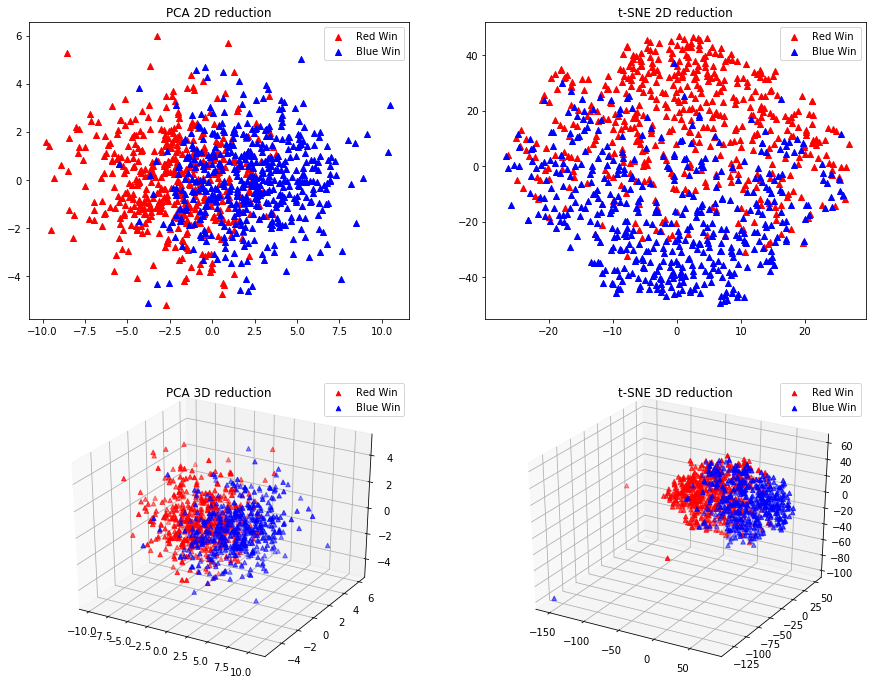

In [58]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

leg = ["Red Win", "Blue Win"]

fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0], projection='3d')
ax4 = fig.add_subplot(gs[1, 1], projection='3d')

ax1.set_title("PCA 2D reduction")
ax2.set_title("t-SNE 2D reduction")
ax3.set_title("PCA 3D reduction")
ax4.set_title("t-SNE 3D reduction")

# PCA 2D reduction
ax1.scatter(X_pca_2D[y==0, 0], X_pca_2D[y==0, 1], c="red", marker="^")
ax1.scatter(X_pca_2D[y==1, 0], X_pca_2D[y==1, 1], c="blue", marker="^")

# t-SNE 2D reduction
ax2.scatter(X_tsne_2D[y==0, 0], X_tsne_2D[y==0, 1], c="red", marker="^")
ax2.scatter(X_tsne_2D[y==1, 0], X_tsne_2D[y==1, 1], c="blue", marker="^")

# PCA 3D reduction
ax3.scatter(X_pca_3D[y==0, 0], X_pca_3D[y==0, 1], X_pca_3D[y==0, 2], c="red", marker="^")
ax3.scatter(X_pca_3D[y==1, 0], X_pca_3D[y==1, 1], X_pca_3D[y==1, 2], c="blue", marker="^")

# t-SNE 3D reduction
ax4.scatter(X_tsne_3D[y==0, 0], X_tsne_3D[y==0, 1], X_tsne_3D[y==0, 2], c="red", marker="^")
ax4.scatter(X_tsne_3D[y==1, 0], X_tsne_3D[y==1, 1], X_tsne_3D[y==1, 2], c="blue", marker="^")

ax1.legend(leg)
ax2.legend(leg)
ax3.legend(leg)
ax4.legend(leg)

plt.show()

The data is not linearly seperable at 2 or 3 dimensions, which means we will most likely need many more features to accurately predict the game winner.